In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
import sys

warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')
from pydens import Solver, NumpySampler, cart_prod, add_tokens, plot_loss, plot_sections_3d
add_tokens()

# Constants & system of equations

* Q1: What are the scales of variables? Is, say, $p_o$ is measured in hundreds or hundreds of millions?
* Q2: What is the time-range?

<tr>
<td> <img src="params_1.png" alt="Drawing" style="width: 500px; height: 550px"/> </td>
<td> <img src="params_2.png" alt="Drawing" style="width: 500px; height: 200px"/> </td>
</tr>

In [101]:
m = (0.1 + 0.3) / 2
g = 9.81

k_o = (0.1 + 10) / 2
mu_o = (0.5 + 1) / 2
b_o = (1.1 + 1.5) / 2
rho_o = (750 + 950) / 2
coeff_o = k_o / (mu_o*b_o)
Q_o = 5 #(10 + 500) / 2  # Q_o and Q_w are of different signs

k_w = (0.1 + 10) / 2
mu_w = (0.2 + 12) / 2
b_w = (1.0 + 1.02) / 2
rho_w = (980 + 1040) / 2
coeff_w = k_w / (mu_w*b_w)
Q_w = -5 #(10 + 500) / 2  # Q_o and Q_w are of different signs

theta = (0.01 + 0.03) / 2
a = (-0.25 - 0.05) / 2
c = (-2 - 4) / 2

$\textbf{Note}$: the equation is set up only with $x$and $t$, we get rid of $y$ and $z$ for simplicity

<img src="equations.png" alt="Drawing" style="width: 400px; height: 150px"/>

In [102]:
(coeff_o-coeff_w)/coeff_w

5.318974358974358

* implement well indicator

In [103]:
# factory making well-indicator
def make_well_ind(c_x, c_y, r):
    return lambda x, y: (1+sign(r**2-((x-c_x)**2+(y-c_y)**2)))/2

In [104]:
ind_o = make_well_ind(0.85, 0.85, 0.1)
ind_w = make_well_ind(0.15, 0.15, 0.1)

In [105]:
# p_ow = lambda s_w: (2*theta / np.sqrt(k_o/m)) / (a*(1 - s_w)/(1 + c*s_w))
p_ow = lambda s_w: 0
eq_1 = lambda p_w, s_w, x, y, t: div(coeff_o*D(p_w + p_ow(s_w)), length=2) - ((m / b_o)*D(1 - s_w, t) 
                                                                              + Q_o*ind_o(x, y))
eq_2 = lambda p_w, s_w, x, y, t: div(coeff_w*D(p_w), length=2) - ((m / b_w)*D(s_w, t)
                                                                  + Q_w*ind_w(x, y))

In [106]:
initial_condition = [[90], [0.3]]

## Training `PyDEns`-model

In [108]:
pde = {'n_dims': 3, 'n_funs': 2, 'n_eqns': 2,
       'form': [eq_1,
                eq_2],
       'initial_condition': initial_condition,
       'time_multiplier': 'sigmoid'}

# Put it all together in model-config
config = {'pde': pde,
          'decay': {'name': 'invtime', 'learning_rate': 0.01,
                    'decay_steps': 100, 'decay_rate': 0.05},
          'track': {'p_w': lambda p_w, s_w, x, y, t: p_w,
                    'p_o': lambda p_w, s_w, x, y, t: p_w + p_ow(s_w),
                    's_w': lambda p_w, s_w, x, y, t: s_w,
                    's_o': lambda p_w, s_w, x, y, t: 1 - s_w,
                    'Q_o': lambda p_w, s_w, x, y, t: Q_o*ind_o(x, y),
                    'Q_w': lambda p_w, s_w, x, y, t: Q_w*ind_w(x, y)}}

# Uniform sampling scheme
s = NumpySampler('u', dim=2) & NumpySampler('u') # decrease the time-range for better fit

In [128]:
# train the network on batches of 100 points
dg = Solver(config, layer_size=60)
dg.fit(batch_size=1000, sampler=s, n_iters=8000, bar='notebook')

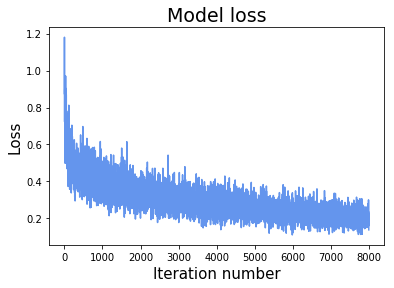

In [129]:
# Plot loss
plot_loss(dg.loss[:], color='cornflowerblue')

# Time-sections of approximate solutions

# $P_w$

* imshow-view

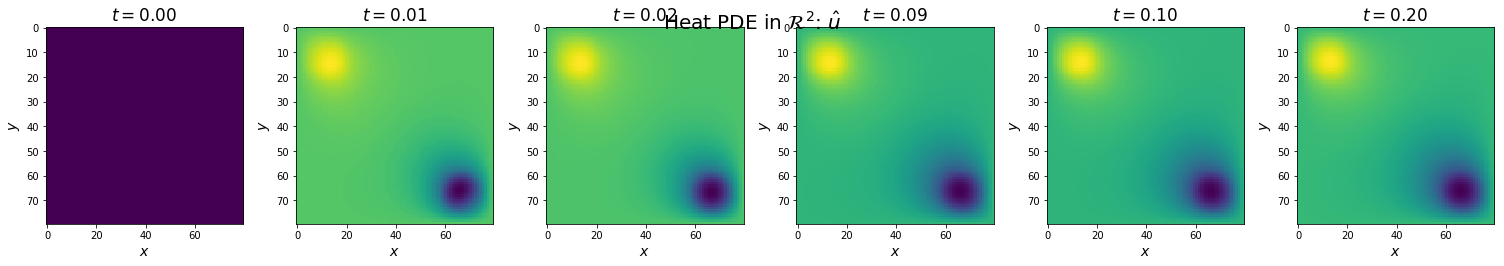

In [136]:
plot_sections_3d(dg, fetches='p_w',
                 mode='imshow',
                 zlim=(89.998, 90.002),
                 grid_size=(1, 6),
                 timestamps=(0, 0.005, 0.02, 0.09, 0.1, 0.2))

* cannot understand the dynamics of values! Let's check out the mean-value of pressure.

In [140]:
def get_mean_value_at_time(model, t, grid=None, num_points=100, xlim=(0, 1), ylim=(0, 1),
                           fetches='p_w'):
    if grid is None:
        xs = np.linspace(*xlim, num_points)
        ys = np.linspace(*ylim, num_points)
        grid = cart_prod(xs, ys)

    grid_t = np.concatenate([grid, t * np.ones((grid.shape[0], 1))], axis=1)
    return np.mean(model.solve(grid_t, fetches=fetches))

In [157]:
get_mean_value_at_time(dg, 0.001)

89.99999

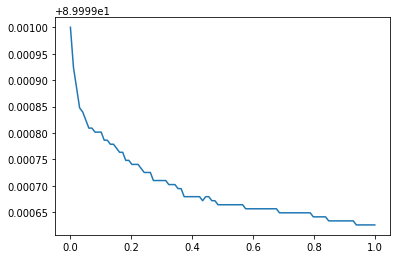

In [164]:
plt.plot(np.linspace(0, 1, 100), [get_mean_value_at_time(dg, t) for t in np.linspace(0, 1, 100)])

# $S_w$

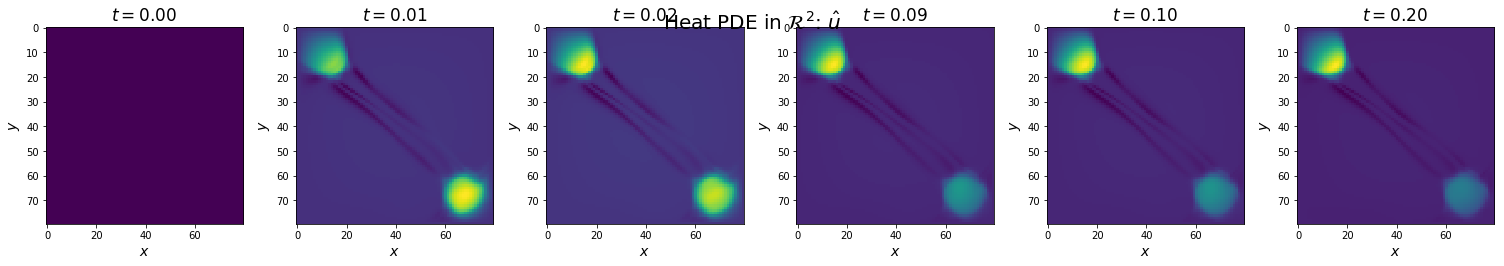

In [137]:
plot_sections_3d(dg, fetches='s_w', zlim=(0.6985, .700001),
                 grid_size=(1, 6), mode='imshow',
                 timestamps=(0, 0.005, 0.02, 0.09, 0.1, 0.2))